<a href="https://colab.research.google.com/github/bahadirbasaran/pulsarDetection/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Environment**

In [0]:
import time
import copy
import pydot
import numpy as np
import pandas as pd
import seaborn as sb
from graphviz import Source
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from warnings import simplefilter
from xgboost import XGBClassifier
from IPython.display import display
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.exceptions import FitFailedWarning
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, cohen_kappa_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, roc_auc_score, average_precision_score  
simplefilter("ignore", UserWarning)
simplefilter("ignore", FutureWarning)
simplefilter("ignore", FitFailedWarning)

**Function&Class Definitions**

In [0]:
def hover(hover_color="#e6e6ff"):
  return dict(selector="tr:hover", props=[("background-color", "%s" % hover_color), ("font-weight", "bold")])

def printDataframe(dataframe, frame_style, sort_by, ascending=False):
  dataframe = dataframe.sort_values(by=sort_by, ascending=ascending)
  display(dataframe.style.set_table_styles(frame_style).hide_index())

def plot_2D_space(X, y, label='Classes'):   
  colors = ['#1F77B4', '#FF7F0E']
  markers = ['o', 's']
  for l, c, m in zip(np.unique(y), colors, markers):
    plt.scatter(X[y==l, 0], X[y==l, 1], c=c, label=l, marker=m)
  plt.title(label, fontsize=16)
  plt.legend(loc='upper right')
  plt.show()

def plot_roc_curve(classifier, y_true, probabilities):
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, probabilities)
  score_roc_auc = roc_auc_score(y_true, probabilities)
  plt.figure(figsize=(10,5))
  plt.plot(false_positive_rate, true_positive_rate, color='orange', label=('AUC Score: ', "%.3f" % score_roc_auc))
  plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve of {}'.format(classifier), fontsize=16)
  plt.legend(loc='best')
  plt.show()

def plot_precision_recall_curve(classifier, y_true, y_pred, probabilities):
  score_avg_precision = "%.3f" % average_precision_score(y_true, y_pred)
  precisions, recalls, thresholds = precision_recall_curve(y_true, probabilities)
  plt.figure(figsize=(10,5))
  plt.plot(recalls, precisions, marker='.', label=classifier)
  plt.title("{} Average Precision: {}".format(classifier, score_avg_precision), fontsize=16)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(loc='best')
  plt.show()

def plot_confusion_matrix(classifier, y_true, y_pred):
  plt.figure(figsize=(10,5))
  sb.heatmap(confusion_matrix(y_true,y_pred),annot=True,fmt = "d",linecolor="k",linewidths=3)
  plt.title("Confusion Matrix of {}".format(classifier), fontsize=16)
  plt.show()

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
  plt.figure(figsize=(10,5))
  plt.title(title, fontsize=16)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel("Training Examples")
  plt.ylabel("Score")
  train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
  plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
  plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")
  plt.legend(loc="best")
  plt.show()

def plot_feature_importances(classifier, data):
  plt.figure(figsize=(10,5))
  featureImportances = pd.Series(classifier.feature_importances_, index=data.columns[:-1]).sort_values(ascending=False)
  sb.barplot(x=featureImportances, y=featureImportances.index)
  plt.title('Feature Importances', fontsize=16)
  plt.xlabel('Score')
  plt.show()

def plot_decision_tree(classifier, featureNames, rotate=True):
  %matplotlib inline
  dot_data = export_graphviz(classifier, out_file=None, rotate=rotate, feature_names=featureNames, filled=True, rounded=True,special_characters=True)
  pdot = pydot.graph_from_dot_data(dot_data)
  # Access element [0] because graph_from_dot_data actually returns a list of DOT elements.
  pdot[0].set_graph_defaults(size = "\"20,20\"")
  graph = Source(pdot[0].to_string())
  return graph

def evaluateClassifier(classifier, y_true, y_pred, probabilities, elapsedTime, df_stats):  
  score_acc = accuracy_score(y_true,y_pred)
  print("\nAccuracy Score of {}: {}".format(classifier, "%.3f" % score_acc))

  score_mse = mean_squared_error(y_true, y_pred)
  print("\nMean Squared Error Score of {}: {}".format(classifier, "%.3f" % score_mse))

  score_cohenKappa = cohen_kappa_score(y_true, y_pred)
  print("\nCohen Kappa Score of {}: {}".format(classifier, "%.3f" % score_cohenKappa))

  classificationReport = classification_report(y_true, y_pred)
  print("\nClassification Report of {}:\n\n{}".format(classifier, classificationReport))

  plot_confusion_matrix(classifier, y_true, y_pred)

  plot_roc_curve(classifier, y_true, probabilities)

  plot_precision_recall_curve(classifier, y_true, y_pred, probabilities)

  if classifier not in df_stats.values:
    df_stats = df_stats.append({"Model": classifier, "Accuracy": "%.4f" % score_acc, "MSE": "%.4f" % score_mse, "Cohen Kappa Score": "%.4f" % score_cohenKappa, "Training Time(Best Estimator)":elapsedTime}, ignore_index=True)

  return df_stats

def createDataSplits(dataset, list_dataColumns, targetColumn, testSizeRatio, randomState=42, oversample=True, obj_preprocessing=None, printStats=True):   
  X = dataset[dataset.columns[list_dataColumns]]
  y = dataset[dataset.columns[targetColumn]]
    
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSizeRatio, random_state=randomState)
    
  if obj_preprocessing is not None:
    X_train = obj_preprocessing.fit_transform(X_train)
    X_test = obj_preprocessing.transform(X_test)
    #Index of X_train and X_test are changed. We must reset the index of y_train and y_test.Otherwise, index mismatch error.
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)    
  
  #Oversampling to balance the data set        
  if oversample == True:
    sm = SMOTE(sampling_strategy='minority', random_state=randomState)
    X_train, y_train = sm.fit_sample(X_train, y_train)   
    plot_2D_space(X_train, y_train, label='Dataset After Oversampling')

  if printStats == True:
    print("\nX_train: {} Samples".format(len(X_train)))
    print("y_train: {} Samples".format(len(y_train)))
    print("X_test:  {}  Samples".format(len(X_test)))
    print("y_test:  {}  Samples".format(len(y_test)))

  return X_train, X_test, y_train, y_test

**Data Import**

In [0]:
dataset = pd.read_csv('https://raw.githubusercontent.com/bahadirbasaran/pulsarDetection/master/pulsar_stars.csv')

**Data Visualization**

Dataset Summary:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 Mean of the integrated profile                  17898 non-null float64
 Standard deviation of the integrated profile    17898 non-null float64
 Excess kurtosis of the integrated profile       17898 non-null float64
 Skewness of the integrated profile              17898 non-null float64
 Mean of the DM-SNR curve                        17898 non-null float64
 Standard deviation of the DM-SNR curve          17898 non-null float64
 Excess kurtosis of the DM-SNR curve             17898 non-null float64
 Skewness of the DM-SNR curve                    17898 non-null float64
target_class                                     17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


Correlation Matrix Heatmap:




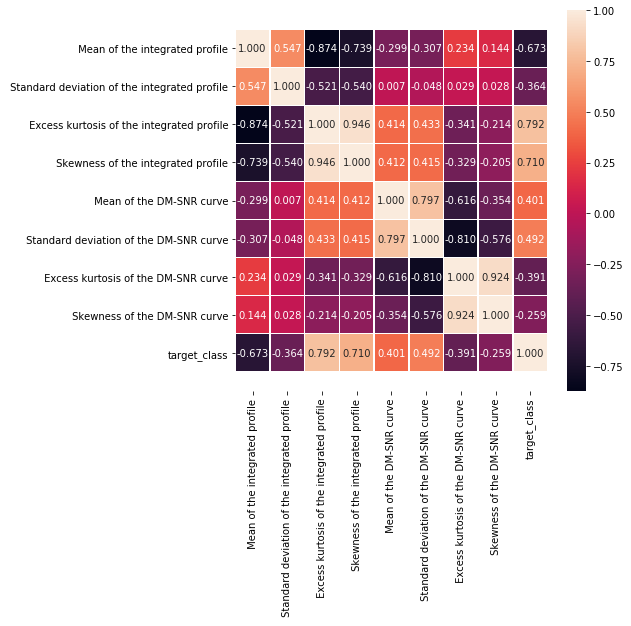



Distribution Plot:



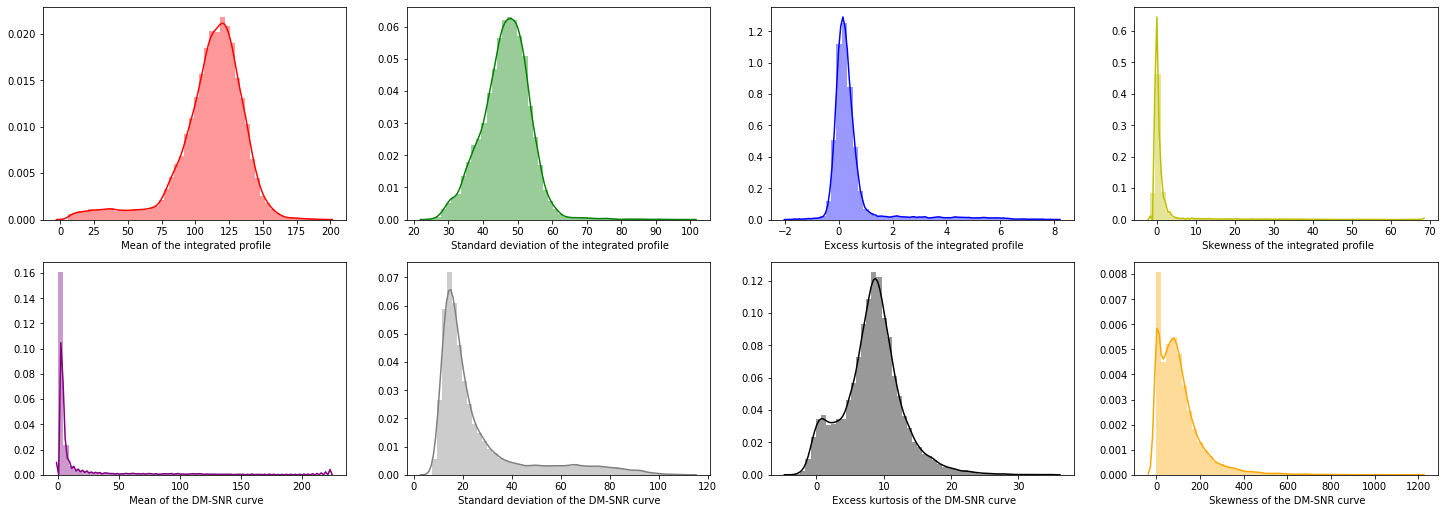



Pair Plot:




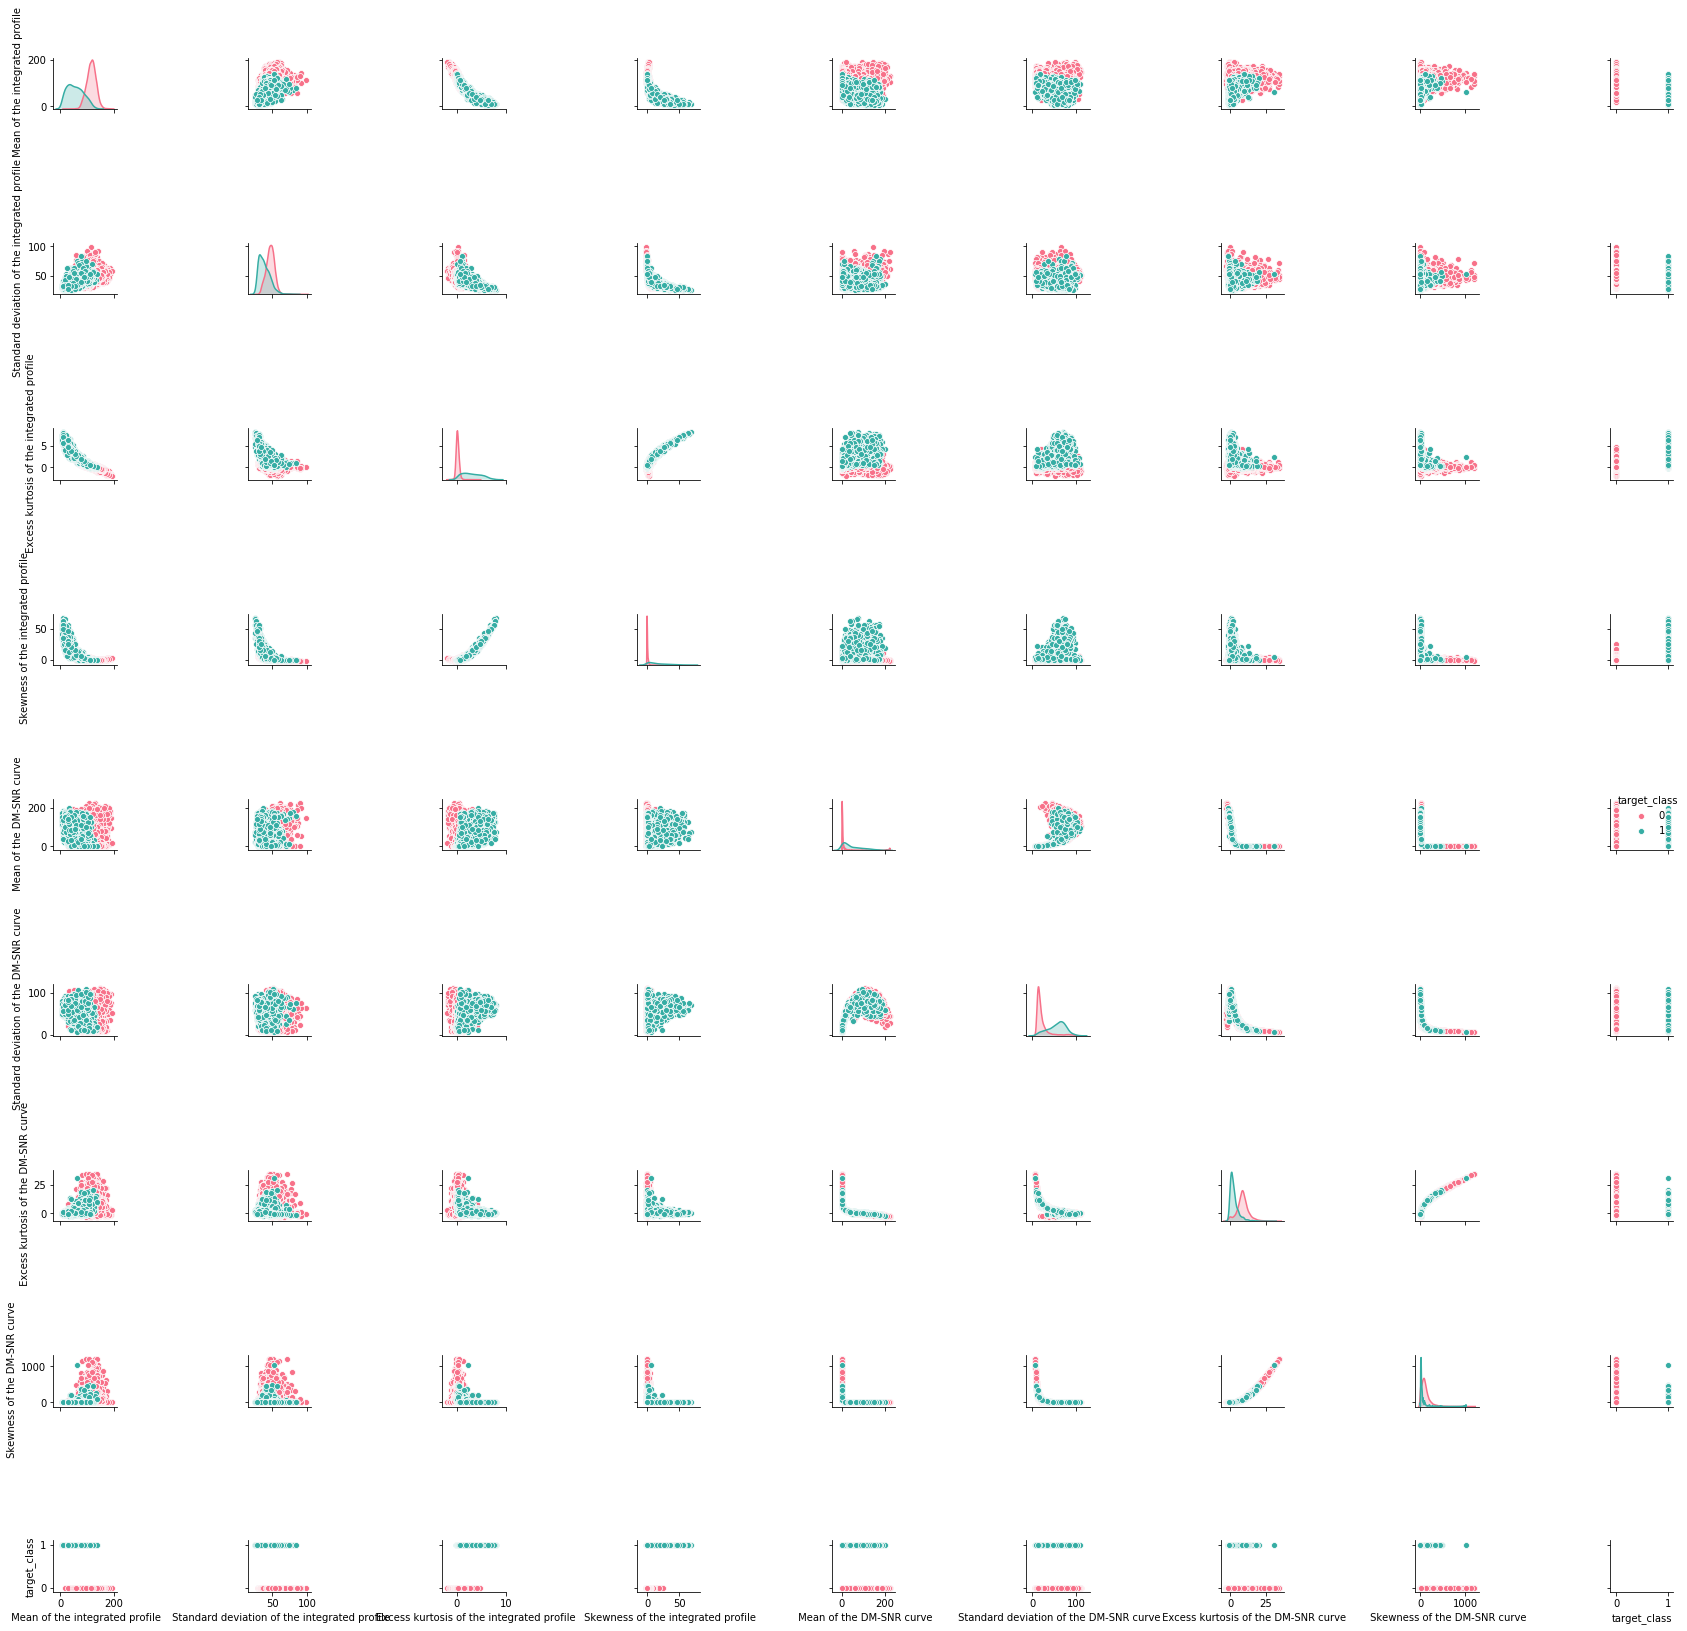



Violin Plot:




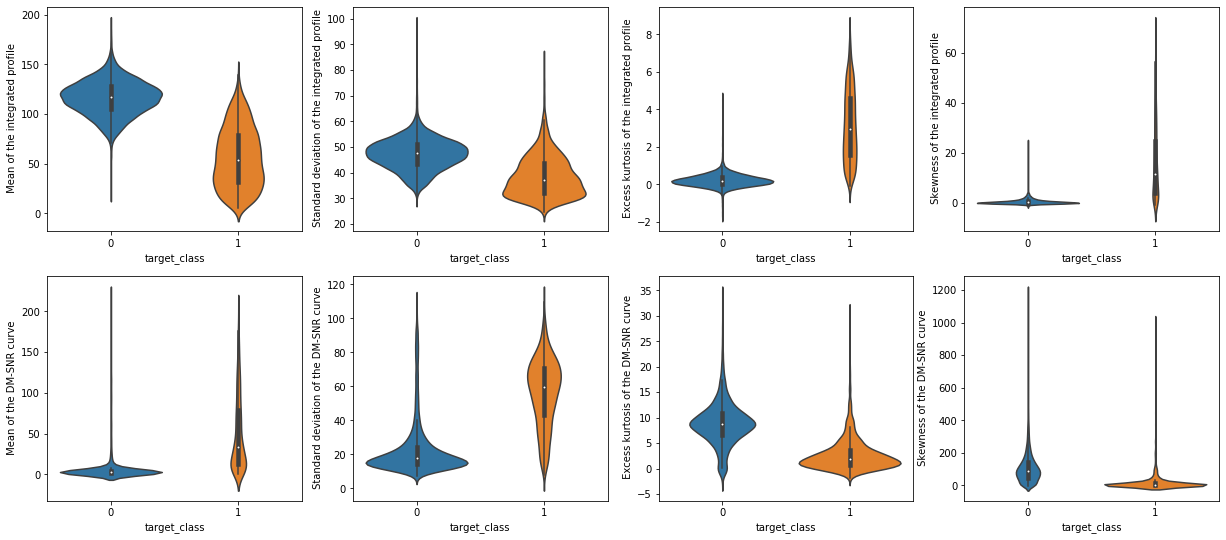



Bar Plot:




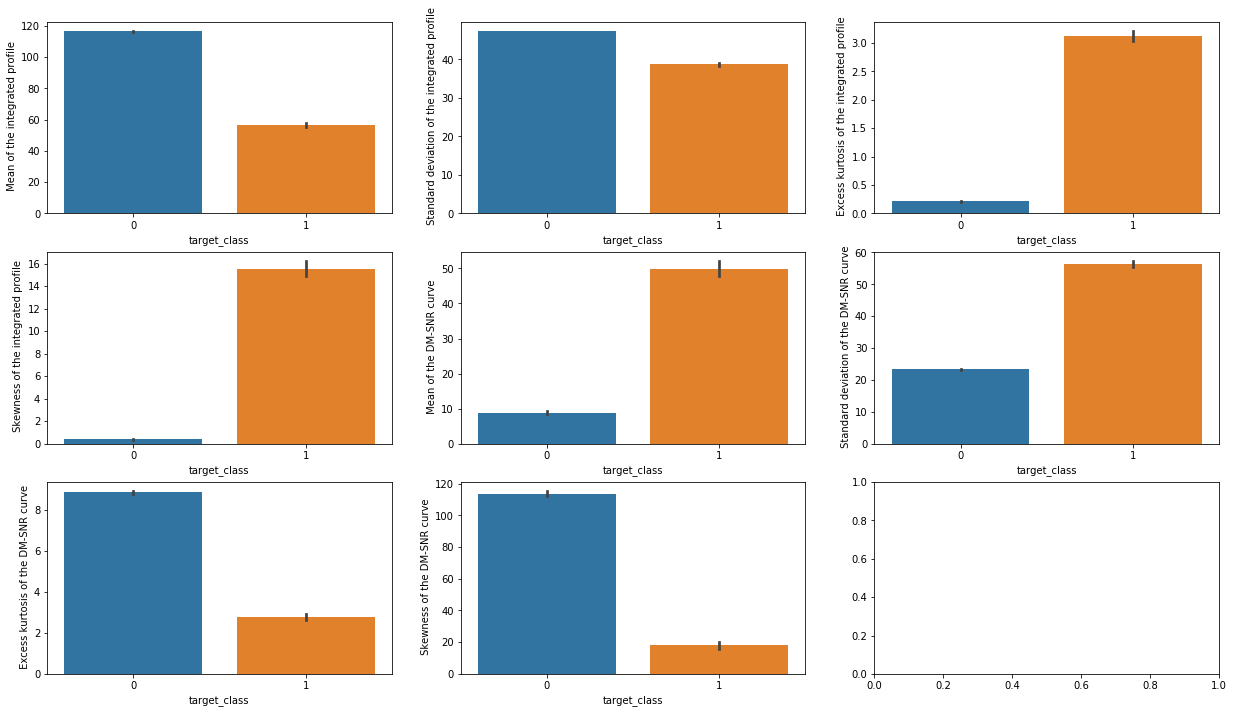



Joint Plot:



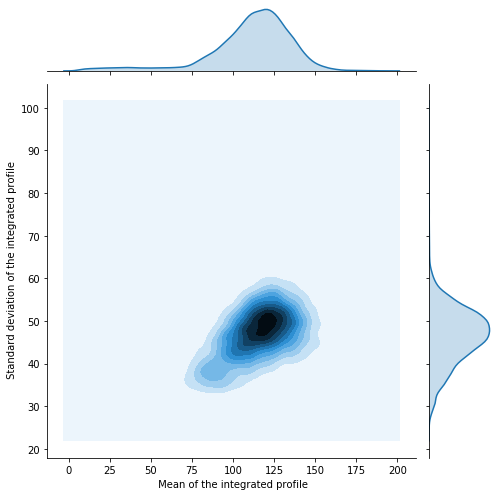

In [0]:
print("Dataset Summary:\n")
dataset.info()
datasetStats = dataset.describe()

# Correlation Matrix Heatmap
print("\n\nCorrelation Matrix Heatmap:\n\n")
_, ax = plt.subplots(figsize = (7,7))
hm = sb.heatmap(dataset.corr(), annot = True, linewidths=.5, fmt = ".3f", ax=ax)
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# Dist Plot
print("\n\nDistribution Plot:\n")
plt.figure(figsize=(25,18))
for i, column, color in zip(list(range(0,8)), dataset.columns[:-1], ['r', 'g', 'b', 'y', 'purple', 'grey', 'black', 'orange']):
  plt.subplot(4,4,i+1)
  sb.distplot(dataset[column], color=color)        
plt.show()

# Pair Plot
print("\n\nPair Plot:\n\n")
sb.pairplot(data=dataset, palette="husl", hue="target_class", vars=list(dataset.columns))
plt.tight_layout()
plt.show()

# Violin Plot
print("\n\nViolin Plot:\n\n")
plt.figure(figsize=(21,19))
for i in range(8):
  plt.subplot(4,4,i+1)
  sb.violinplot(data=dataset, y=dataset.columns[i], x="target_class")
plt.show()

# Bar Plot
print("\n\nBar Plot:\n\n")
_, ax1 = plt.subplots(3,3, figsize=(21,12))
k = 0
for i in range(3):
  for j in range(3):
    if k != 8:
      sb.barplot(x='target_class', y=dataset.columns[k], data=dataset, ax = ax1[i][j])
      k += 1            
plt.show()

# Joint Plot
print("\n\nJoint Plot:\n")
sb.jointplot(x=dataset.columns[0], y=dataset.columns[1], data=dataset, kind='kde', height=7)
plt.show()

**Data Splits**

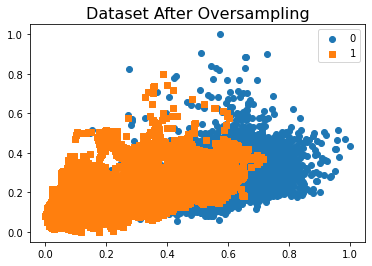


X_train: 26000 Samples
y_train: 26000 Samples
X_test:  3580  Samples
y_test:  3580  Samples


In [19]:
obj_prc = MinMaxScaler()

X_train, X_test, y_train, y_test = createDataSplits(dataset, [0,1,2,3,4,5,6,7], 8, 0.2, obj_preprocessing=obj_prc)


# **Model Preparation&Evaluation**

**Model Preparation**

In [0]:
params_LR =  {"penalty": ['none', 'l2'], 'C': [0.01, 0.1, 1, 10, 100, 1000]}
params_kNN = {"n_neighbors": [3, 5, 7, 9], "weights": ['uniform', 'distance'], "metric": ['euclidean', 'manhattan']}
params_SVC = {'C': [10, 100], 'gamma': ['scale', 0.0015], 'kernel': ['rbf', 'poly'], 'probability': [True], 'max_iter': [2000]}
params_DT =  {"criterion": ["gini", "entropy"], "max_depth": [1, 2, None]}
params_RF =  {"n_estimators": [300], "criterion": ["gini", "entropy"], "max_depth": [1, 2, None]}
params_AB =  {"n_estimators": [300]}
params_BC =  {"n_estimators": [100]}
params_GB =  {"n_estimators": [500], "max_depth": [2, 3], "min_samples_leaf": [2, 3]}
params_XGB = {"n_estimators": [300], "eta": [0.025, 0.05]}
params_ET =  {"n_estimators": [500], "criterion": ["gini", "entropy"], "max_depth": [1, 2, None]}

list_paramSets = [params_LR, params_kNN, params_SVC, params_DT, params_RF, params_AB, params_BC, params_GB, params_XGB, params_ET]

list_classifiers = [LogisticRegression(), KNeighborsClassifier(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(),
                    AdaBoostClassifier(), BaggingClassifier(), GradientBoostingClassifier(), XGBClassifier(), ExtraTreesClassifier()]

list_clfNames = ["Logistic Regression", "k-Nearest Neighbors", "Support Vector Machines", "Decision Tree",
                 "Random Forest", "AdaBoost", "Bagging", "Gradient Boosting", "XGBoost", "Extra Trees"]

dataframe_stats = pd.DataFrame(columns=['Model', 'Accuracy', 'MSE', 'Cohen Kappa Score', 'Training Time(Best Estimator)'])
dataframe_grid = pd.DataFrame(columns=['Parameter Set', 'Mean Test Score'])

frameStyle = [hover(), dict(selector="th", props=[("font-size", "120%"), ("text-align", "left"), ('min-width', '200px')])]
frameStyle2 = [hover(), dict(selector="th", props=[("font-size", "120%"), ("text-align", "left"), ('min-width', '500px')])]

**Model Evaluation**

Logistic Regression

Mean Cross-validated Score of the Best Estimator: 0.944



Parameter Set,Mean Test Score
"{'C': 0.01, 'penalty': 'none'}",0.9438
"{'C': 0.1, 'penalty': 'none'}",0.9438
"{'C': 1, 'penalty': 'none'}",0.9438
"{'C': 1, 'penalty': 'l2'}",0.9438
"{'C': 10, 'penalty': 'none'}",0.9438
"{'C': 100, 'penalty': 'none'}",0.9438
"{'C': 1000, 'penalty': 'none'}",0.9438
"{'C': 1000, 'penalty': 'l2'}",0.9438
"{'C': 10, 'penalty': 'l2'}",0.9437
"{'C': 100, 'penalty': 'l2'}",0.9437



Logistic Regression Parameter Set of the Best Estimator:

	Parameter penalty: none
	Parameter C: 0.01

Accuracy Score of Logistic Regression: 0.970

Mean Squared Error Score of Logistic Regression: 0.030

Cohen Kappa Score of Logistic Regression: 0.830

Classification Report of Logistic Regression:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3259
           1       0.78      0.92      0.85       321

    accuracy                           0.97      3580
   macro avg       0.89      0.95      0.91      3580
weighted avg       0.97      0.97      0.97      3580



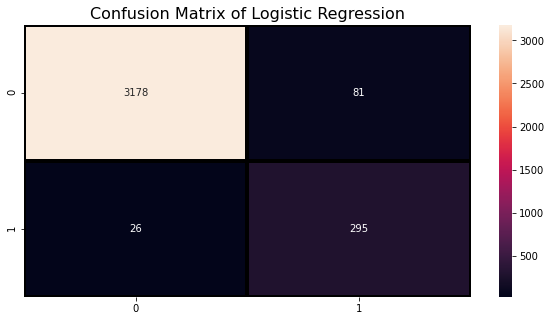

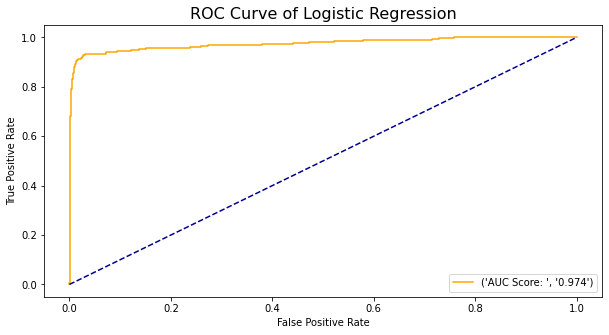

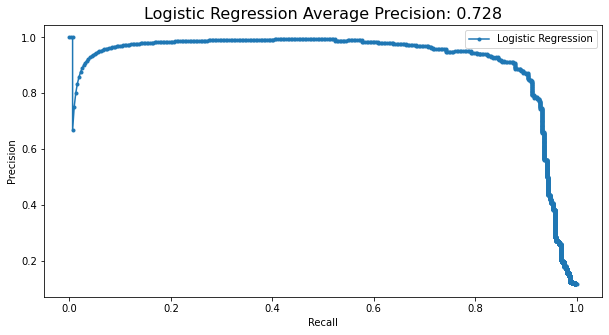

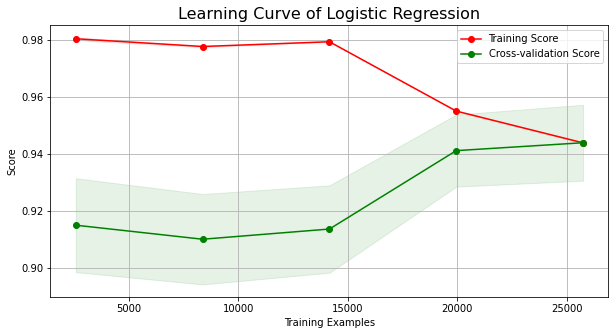

k-Nearest Neighbors

Mean Cross-validated Score of the Best Estimator: 0.974



Parameter Set,Mean Test Score
"{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}",0.9745
"{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}",0.9743
"{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}",0.9733
"{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}",0.9732
"{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}",0.9730
"{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}",0.9728
"{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}",0.9728
"{'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}",0.9722
"{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}",0.9722
"{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}",0.9722



k-Nearest Neighbors Parameter Set of the Best Estimator:

	Parameter n_neighbors: 3
	Parameter weights: distance
	Parameter metric: euclidean

Accuracy Score of k-Nearest Neighbors: 0.947

Mean Squared Error Score of k-Nearest Neighbors: 0.053

Cohen Kappa Score of k-Nearest Neighbors: 0.726

Classification Report of k-Nearest Neighbors:

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3259
           1       0.64      0.91      0.76       321

    accuracy                           0.95      3580
   macro avg       0.82      0.93      0.86      3580
weighted avg       0.96      0.95      0.95      3580



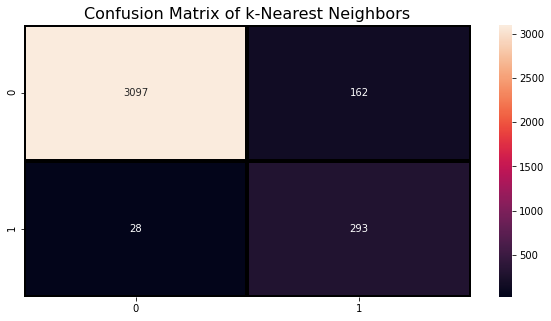

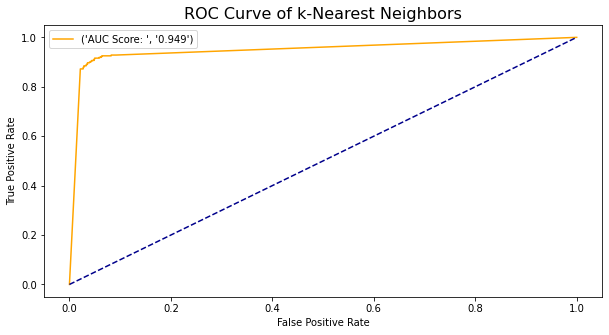

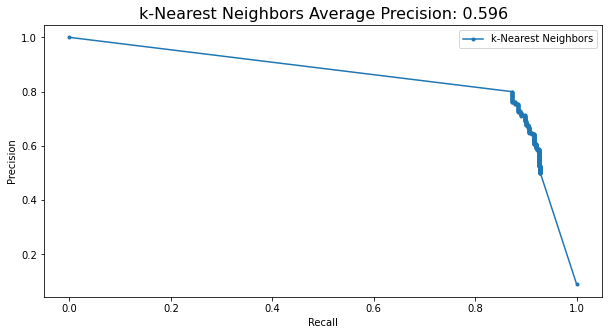

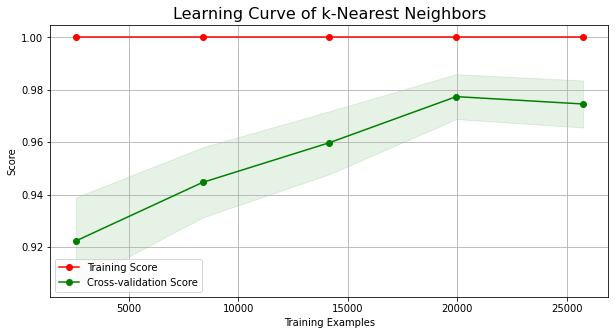

Support Vector Machines

Mean Cross-validated Score of the Best Estimator: 0.950



Parameter Set,Mean Test Score
"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 2000, 'probability': True}",0.9500
"{'C': 10, 'gamma': 0.0015, 'kernel': 'rbf', 'max_iter': 2000, 'probability': True}",0.9034
"{'C': 100, 'gamma': 0.0015, 'kernel': 'rbf', 'max_iter': 2000, 'probability': True}",0.8967
"{'C': 100, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 2000, 'probability': True}",0.6727
"{'C': 100, 'gamma': 0.0015, 'kernel': 'poly', 'max_iter': 2000, 'probability': True}",0.5174
"{'C': 10, 'gamma': 0.0015, 'kernel': 'poly', 'max_iter': 2000, 'probability': True}",0.5172
"{'C': 100, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 2000, 'probability': True}",0.4892
"{'C': 10, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 2000, 'probability': True}",0.4755



Support Vector Machines Parameter Set of the Best Estimator:

	Parameter C: 10
	Parameter gamma: scale
	Parameter kernel: rbf
	Parameter probability: True
	Parameter max_iter: 2000

Accuracy Score of Support Vector Machines: 0.974

Mean Squared Error Score of Support Vector Machines: 0.026

Cohen Kappa Score of Support Vector Machines: 0.849

Classification Report of Support Vector Machines:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3259
           1       0.81      0.92      0.86       321

    accuracy                           0.97      3580
   macro avg       0.90      0.95      0.92      3580
weighted avg       0.98      0.97      0.97      3580



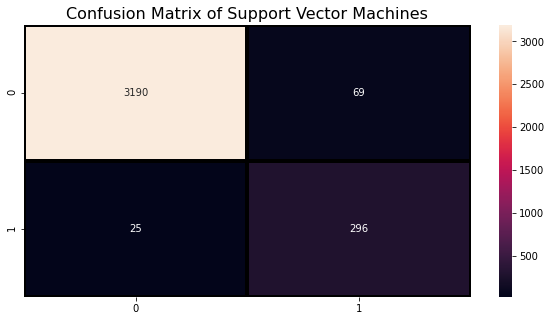

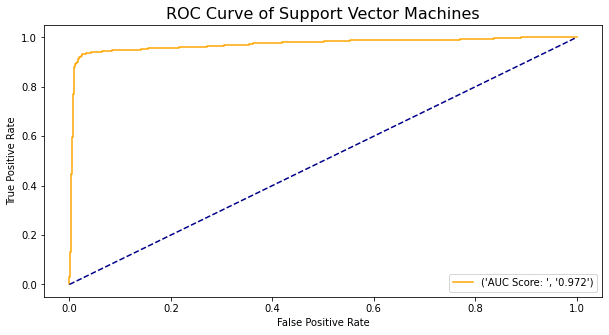

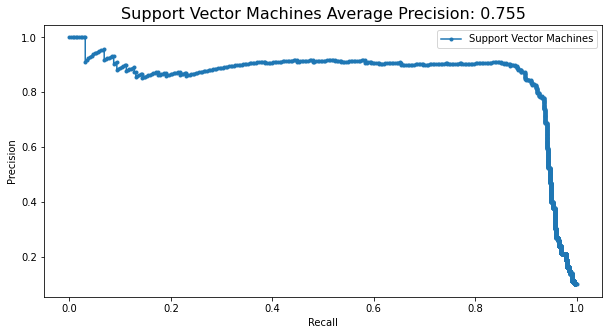

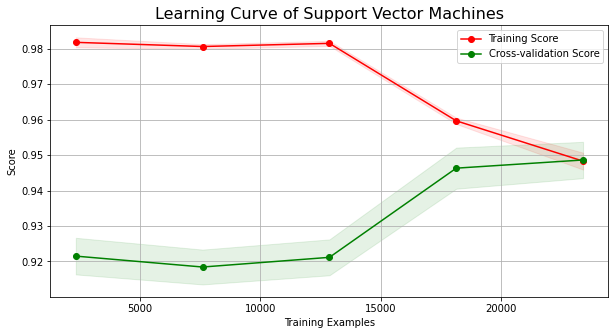

Decision Tree

Mean Cross-validated Score of the Best Estimator: 0.965



Parameter Set,Mean Test Score
"{'criterion': 'entropy', 'max_depth': None}",0.9648
"{'criterion': 'gini', 'max_depth': None}",0.9612
"{'criterion': 'gini', 'max_depth': 1}",0.9265
"{'criterion': 'gini', 'max_depth': 2}",0.9265
"{'criterion': 'entropy', 'max_depth': 1}",0.9261
"{'criterion': 'entropy', 'max_depth': 2}",0.9261



Decision Tree Parameter Set of the Best Estimator:

	Parameter criterion: entropy
	Parameter max_depth: None

Accuracy Score of Decision Tree: 0.949

Mean Squared Error Score of Decision Tree: 0.051

Cohen Kappa Score of Decision Tree: 0.729

Classification Report of Decision Tree:

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3259
           1       0.67      0.88      0.76       321

    accuracy                           0.95      3580
   macro avg       0.83      0.92      0.86      3580
weighted avg       0.96      0.95      0.95      3580



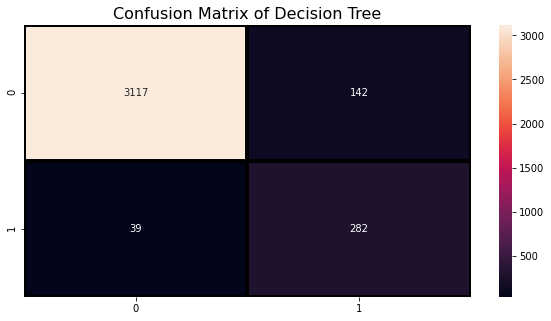

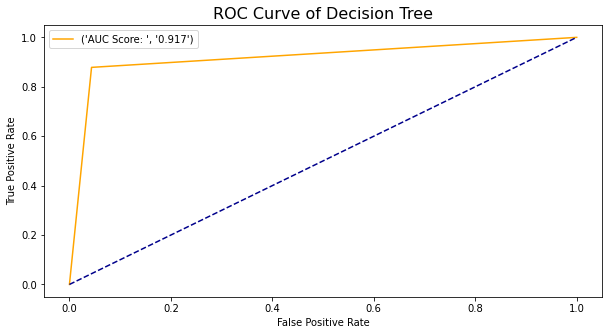

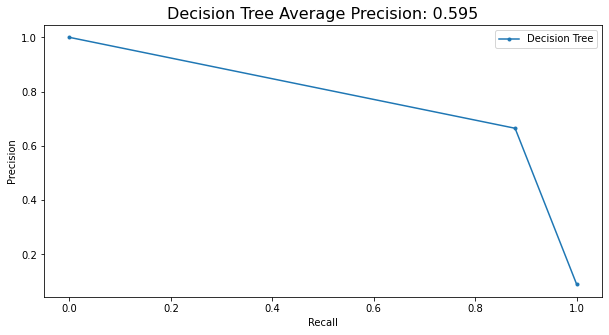

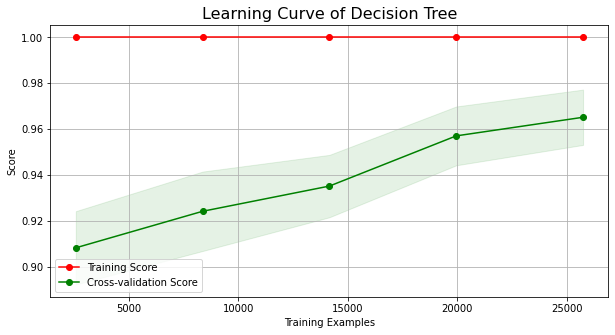

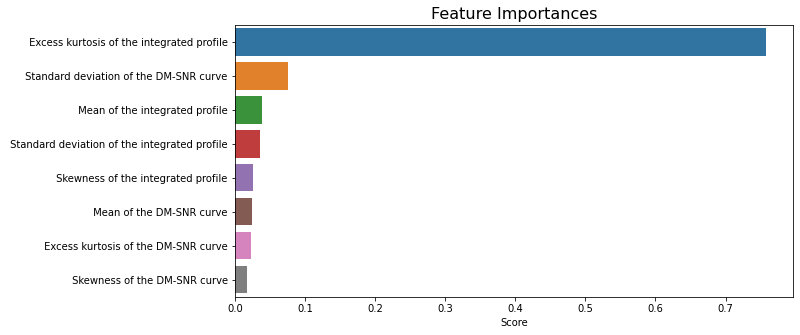

Random Forest

Mean Cross-validated Score of the Best Estimator: 0.979



Parameter Set,Mean Test Score
"{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 500}",0.9785
"{'criterion': 'gini', 'max_depth': None, 'n_estimators': 500}",0.9773
"{'criterion': 'gini', 'max_depth': 2, 'n_estimators': 500}",0.9319
"{'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 500}",0.9294
"{'criterion': 'gini', 'max_depth': 1, 'n_estimators': 500}",0.9202
"{'criterion': 'entropy', 'max_depth': 1, 'n_estimators': 500}",0.9192



Random Forest Parameter Set of the Best Estimator:

	Parameter n_estimators: 500
	Parameter criterion: entropy
	Parameter max_depth: None

Accuracy Score of Random Forest: 0.978

Mean Squared Error Score of Random Forest: 0.022

Cohen Kappa Score of Random Forest: 0.872

Classification Report of Random Forest:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3259
           1       0.86      0.91      0.88       321

    accuracy                           0.98      3580
   macro avg       0.92      0.95      0.94      3580
weighted avg       0.98      0.98      0.98      3580



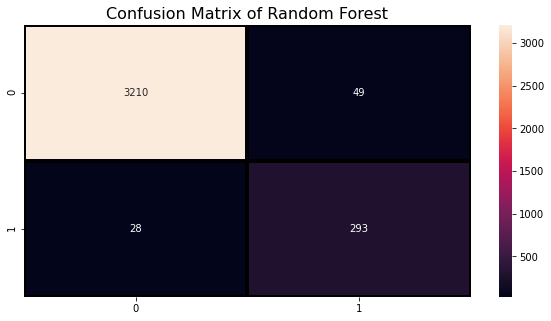

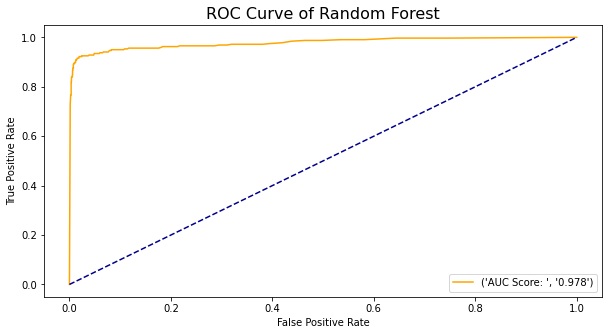

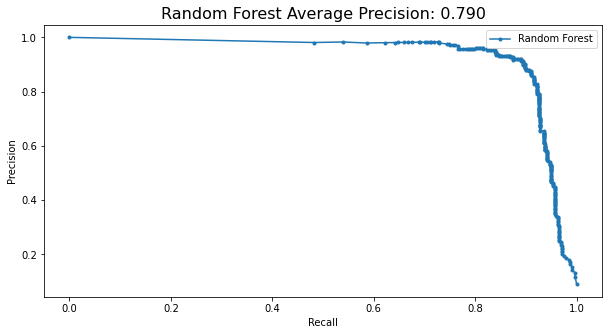

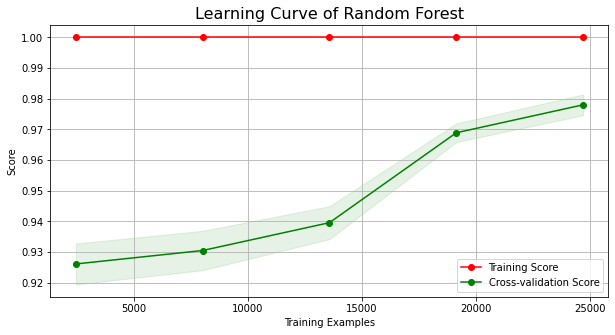

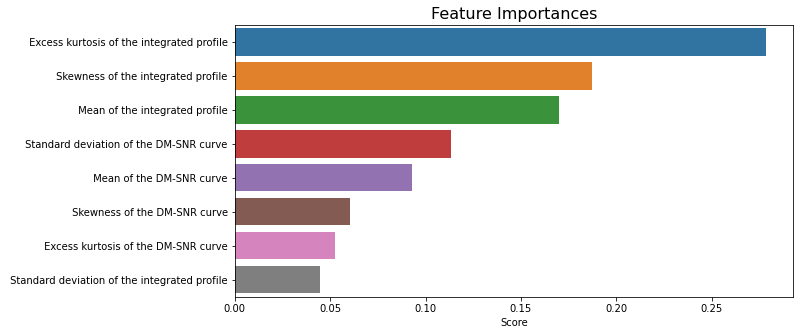

AdaBoost

Mean Cross-validated Score of the Best Estimator: 0.965


AdaBoost Parameter Set of the Best Estimator:

	Parameter n_estimators: 500
	Parameter base_estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Accuracy Score of AdaBoost: 0.951

Mean Squared Error Score of AdaBoost: 0.049

Cohen Kappa Score of AdaBoost: 0.736

Classification Report of AdaBoost:

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3259
           1       0.67      0.89      0.76       321

    accuracy                           0.95      3580
   macro avg       0.83   

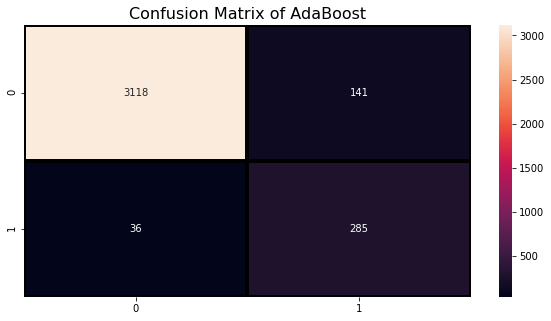

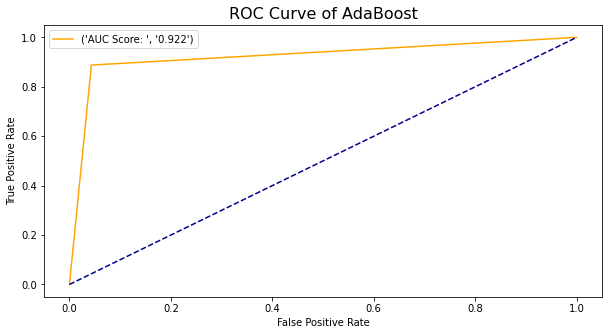

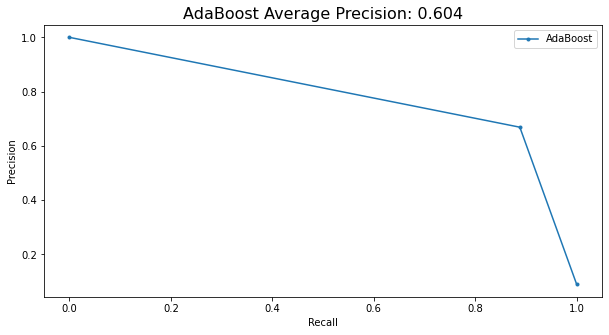

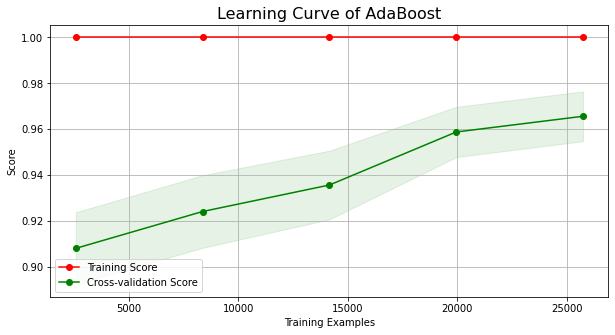

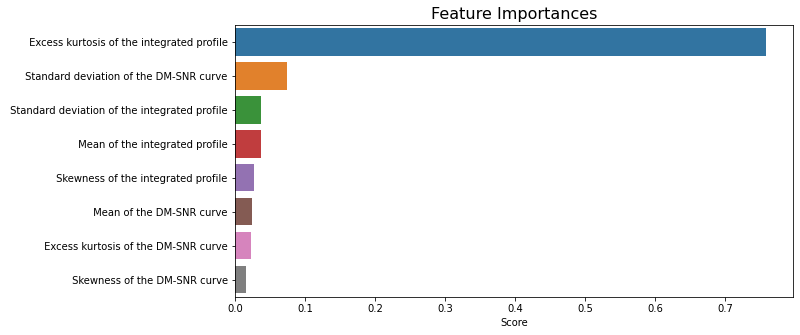

Gradient Boosting

Mean Cross-validated Score of the Best Estimator: 0.960



Parameter Set,Mean Test Score
"{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 500}",0.9598
"{'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 500}",0.9591
"{'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 500}",0.9533
"{'max_depth': 2, 'min_samples_leaf': 3, 'n_estimators': 500}",0.9532



Gradient Boosting Parameter Set of the Best Estimator:

	Parameter n_estimators: 500
	Parameter max_depth: 3
	Parameter min_samples_leaf: 3

Accuracy Score of Gradient Boosting: 0.964

Mean Squared Error Score of Gradient Boosting: 0.036

Cohen Kappa Score of Gradient Boosting: 0.801

Classification Report of Gradient Boosting:

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3259
           1       0.74      0.92      0.82       321

    accuracy                           0.96      3580
   macro avg       0.87      0.95      0.90      3580
weighted avg       0.97      0.96      0.97      3580



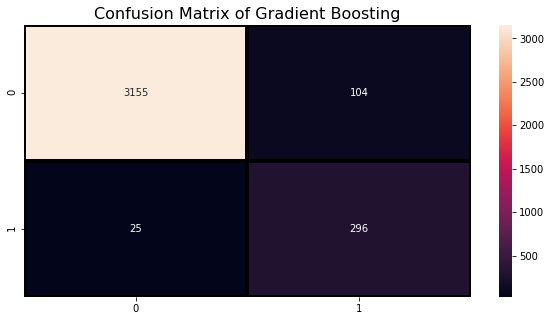

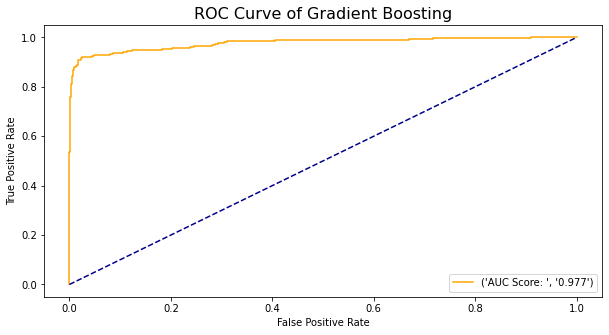

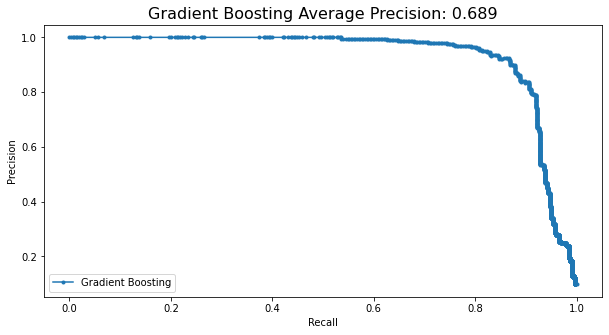

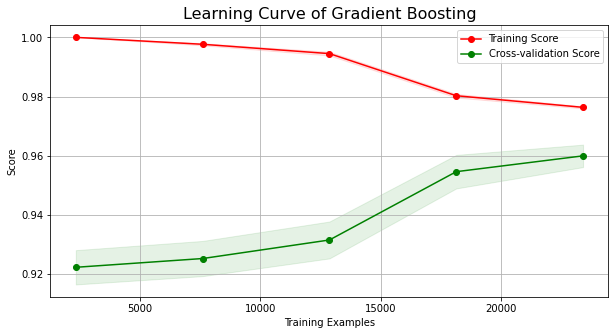

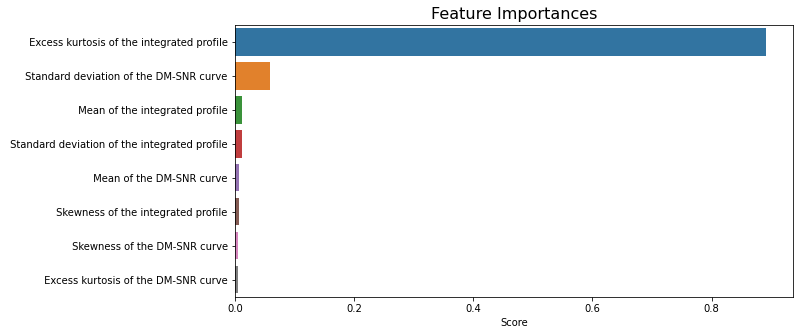

XGBoost

Mean Cross-validated Score of the Best Estimator: 0.963



Parameter Set,Mean Test Score
"{'eta': 0.025, 'n_estimators': 500}",0.9629
"{'eta': 0.04, 'n_estimators': 500}",0.9629
"{'eta': 0.05, 'n_estimators': 500}",0.9629
"{'eta': 0.06, 'n_estimators': 500}",0.9629
"{'eta': 0.075, 'n_estimators': 500}",0.9629



XGBoost Parameter Set of the Best Estimator:

	Parameter n_estimators: 500
	Parameter eta: 0.025

Accuracy Score of XGBoost: 0.965

Mean Squared Error Score of XGBoost: 0.035

Cohen Kappa Score of XGBoost: 0.803

Classification Report of XGBoost:

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3259
           1       0.75      0.92      0.82       321

    accuracy                           0.96      3580
   macro avg       0.87      0.94      0.90      3580
weighted avg       0.97      0.96      0.97      3580



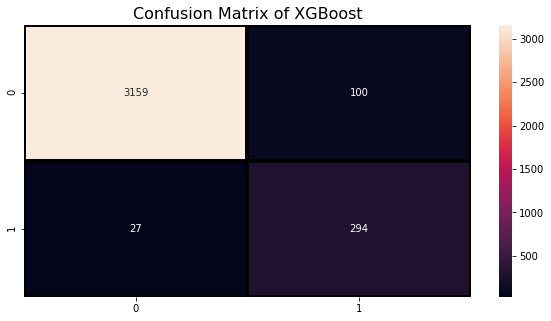

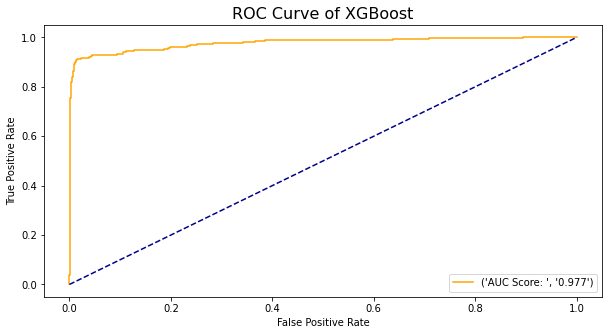

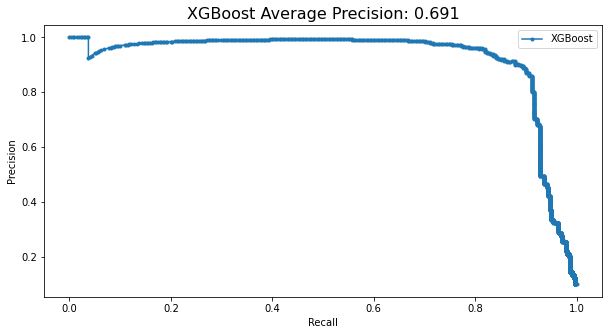

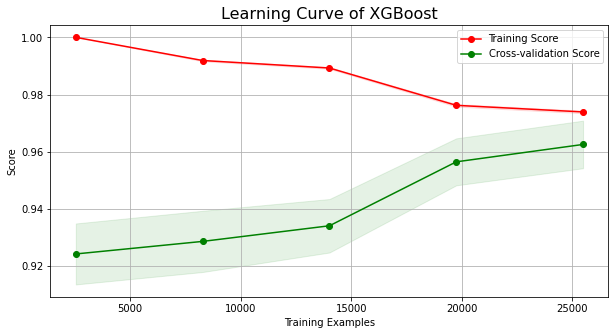

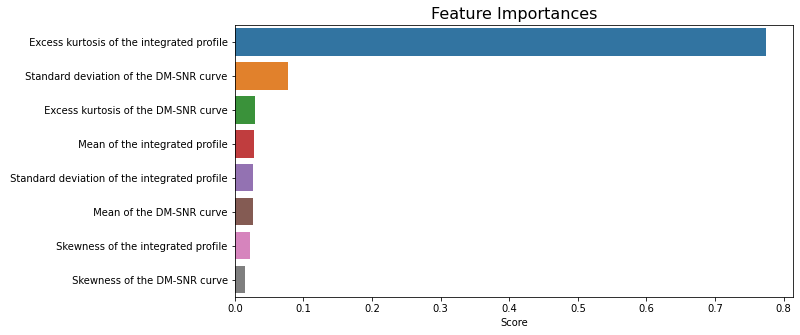

Extra Trees

Mean Cross-validated Score of the Best Estimator: 0.983



Parameter Set,Mean Test Score
"{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 500}",0.9830
"{'criterion': 'gini', 'max_depth': None, 'n_estimators': 500}",0.9826
"{'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 500}",0.9082
"{'criterion': 'gini', 'max_depth': 2, 'n_estimators': 500}",0.9065
"{'criterion': 'gini', 'max_depth': 1, 'n_estimators': 500}",0.8939
"{'criterion': 'entropy', 'max_depth': 1, 'n_estimators': 500}",0.8927



Extra Trees Parameter Set of the Best Estimator:

	Parameter n_estimators: 500
	Parameter criterion: entropy
	Parameter max_depth: None

Accuracy Score of Extra Trees: 0.980

Mean Squared Error Score of Extra Trees: 0.020

Cohen Kappa Score of Extra Trees: 0.881

Classification Report of Extra Trees:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3259
           1       0.88      0.90      0.89       321

    accuracy                           0.98      3580
   macro avg       0.94      0.94      0.94      3580
weighted avg       0.98      0.98      0.98      3580



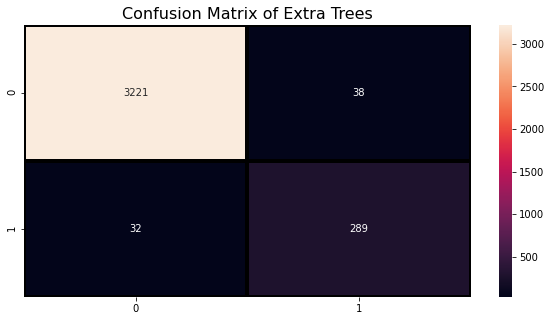

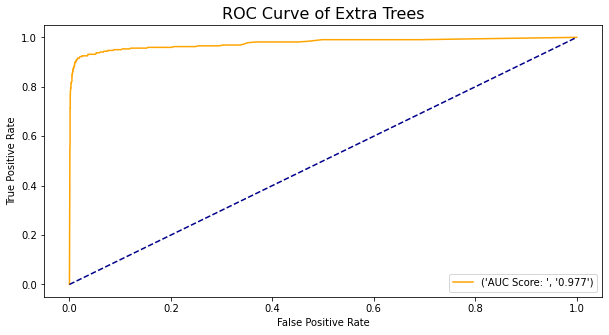

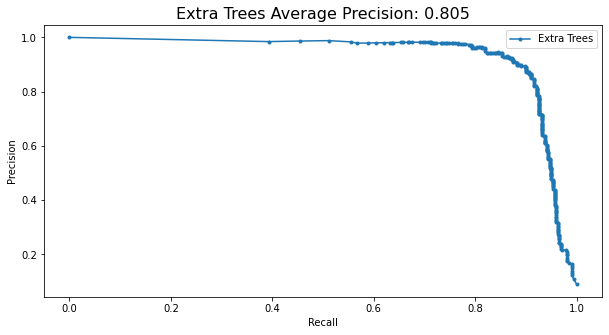

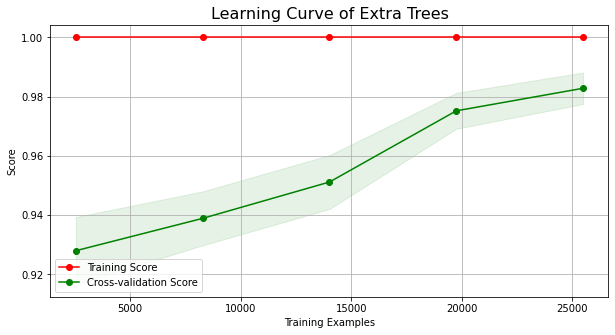

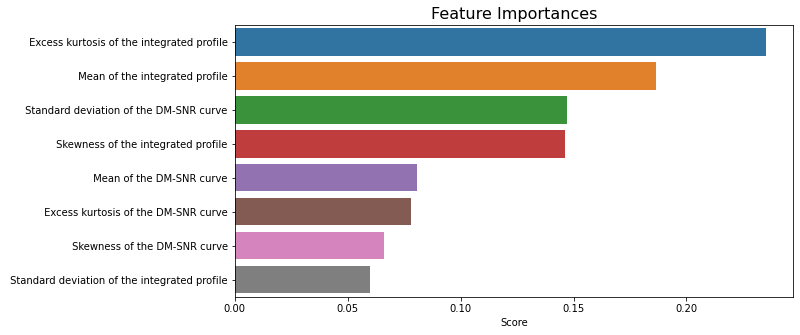

Naive Bayes

Mean Cross-validated Score: 0.905

Accuracy Score of Naive Bayes: 0.939

Mean Squared Error Score of Naive Bayes: 0.061

Cohen Kappa Score of Naive Bayes: 0.683

Classification Report of Naive Bayes:

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3259
           1       0.61      0.87      0.72       321

    accuracy                           0.94      3580
   macro avg       0.80      0.91      0.84      3580
weighted avg       0.95      0.94      0.94      3580



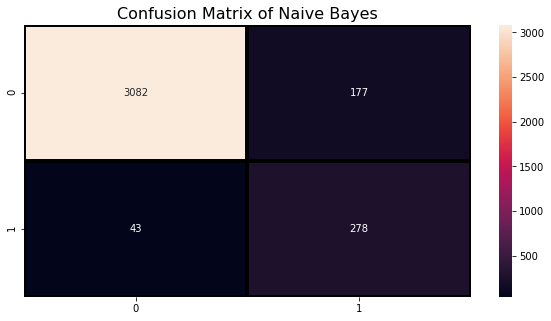

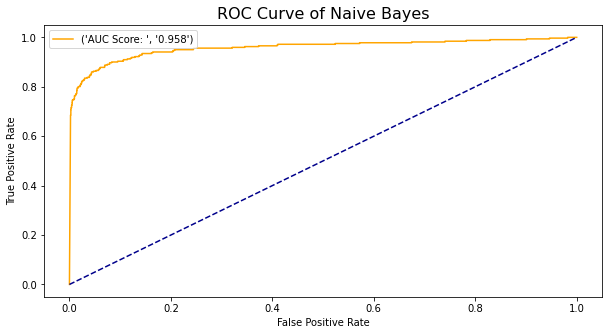

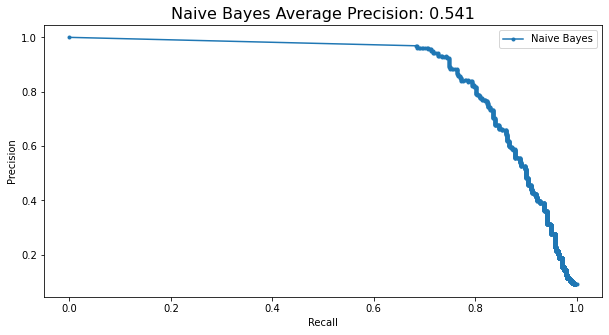

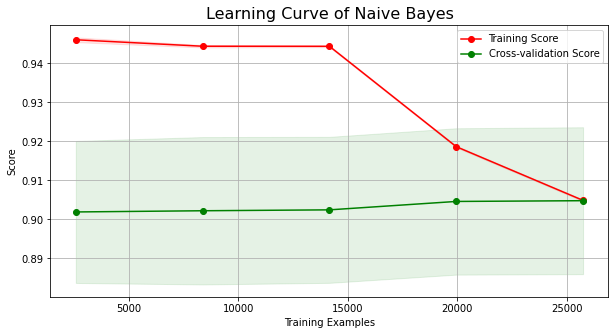

Model,Accuracy,MSE,Cohen Kappa Score,Training Time(Best Estimator)
Extra Trees,0.9804,0.0196,0.8812,929.07
Random Forest,0.9785,0.0215,0.8720,1703.45
Support Vector Machines,0.9737,0.0263,0.8485,1459.40
Logistic Regression,0.9701,0.0299,0.8300,168.73
XGBoost,0.9645,0.0355,0.8029,2152.16
Gradient Boosting,0.9640,0.0360,0.8013,1349.67
AdaBoost,0.9506,0.0494,0.7361,39.20
Decision Tree,0.9494,0.0506,0.7294,90.93
k-Nearest Neighbors,0.9469,0.0531,0.7264,79.37
Naive Bayes,0.9385,0.0615,0.6832,0.006


In [0]:
for classifier, paramSet, classifierName in zip(list_classifiers, list_paramSets, list_clfNames):
  
  if classifierName in ["Support Vector Machines", "Gradient Boosting"]:
    n_folds = 10
  elif classifierName == "Random Forest":
    n_folds = 20
  else:
    n_folds = 50
  
  gs = GridSearchCV(
                    estimator = classifier,
                    param_grid = paramSet,
                    cv = n_folds              
                   )  
  startTime = time.time()
  gs.fit(X_train, y_train)
  elapsedTime = "%.2f" % (time.time() - startTime)

  print(classifierName)
  print("\nMean Cross-validated Score of the Best Estimator: {}\n".format("%.3f" % gs.best_score_))

  if classifierName not in ["AdaBoost", "Bagging"]:   
    dataframe_grid = dataframe_grid.iloc[0:0]
    for param, i in zip(gs.cv_results_['params'], range(0, len(gs.cv_results_['params']))):
      dataframe_grid = dataframe_grid.append({"Parameter Set": param, "Mean Test Score": "%.4f" % gs.cv_results_['mean_test_score'][i]}, ignore_index=True) 
    printDataframe(dataframe=dataframe_grid, frame_style=frameStyle2, sort_by='Mean Test Score')

  print("\n{} Parameter Set of the Best Estimator:\n".format(classifierName))
  for param in paramSet.keys():
    print("\tParameter {}: {}".format(param, gs.best_estimator_.get_params()[param]))
  
  y_pred = gs.best_estimator_.predict(X_test)

  #Predict probabilities for the test data and Keep Probabilities of the positive class only.
  probs = gs.best_estimator_.predict_proba(X_test)[:, 1]

  dataframe_stats = evaluateClassifier(classifierName, y_test, y_pred, probs, elapsedTime, dataframe_stats)

  cv = KFold(n_splits=n_folds, shuffle=True)
  title = "Learning Curve of " + classifierName
  plot_learning_curve(gs.best_estimator_, title, X_train, y_train, cv=cv)

  #If a classifier belongs to the list below, in order to draw the feature importances:
  if classifierName in ["Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting", "XGBoost", "Extra Trees"]:
    plot_feature_importances(gs.best_estimator_, dataset)

    if classifierName == "Decision Tree":
      #Best estimator that is the result of DecisionTreeClassifier will be used in AdaBoostClassifier and BaggingClassifier
      params_AB.update({"base_estimator": [gs.best_estimator_]})
      params_BC.update({"base_estimator": [gs.best_estimator_]})

      #In case of need, it is possible to plot the decision tree. It is disabled below because of the size for such dataset.
      #plot_decision_tree(gs.best_estimator_, dataset.columns[:-1])

# We cannot use Naive Bayes Classifier with GridSearchCV
clf_NB = GaussianNB() 

foldScores = cross_val_score(clf_NB, X_train, y_train, cv=100)

startTime = time.time()
clf_NB.fit(X_train, y_train)
elapsedTime = "%.3f" % (time.time() - startTime)

y_pred = clf_NB.predict(X_test)
probs = clf_NB.predict_proba(X_test)[:, 1]

print("Naive Bayes")
print("\nMean Cross-validated Score: {}".format("%.3f" % foldScores.mean()))

dataframe_stats = evaluateClassifier("Naive Bayes", y_test, y_pred, probs, elapsedTime, dataframe_stats)

cv = KFold(n_splits=100, shuffle=True)
plot_learning_curve(clf_NB, "Learning Curve of Naive Bayes", X_train, y_train, cv=cv)

#Listing the results
printDataframe(dataframe=dataframe_stats, frame_style=frameStyle, sort_by='Accuracy')